In [411]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.deterministic import Fourier, DeterministicProcess
from statsmodels.tsa.api import AutoReg

from pmdarima.arima import auto_arima

from matplotlib import pyplot as plt
import seaborn as sns

import itertools

from setup import get_task_data

START_INDEX = 10500
TRAIN_TEST_RATIO = 0.9

In [412]:
pd.plotting.register_matplotlib_converters()
TASK_DATA_NAME = 'AMD.csv'

df = pd.read_csv(get_task_data(TASK_DATA_NAME))

df.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
4364,1997-06-19,19.3750,19.3750,18.8125,18.9375,18.9375,4802200
7136,2008-06-26,6.3300,6.3300,6.0000,6.1300,6.1300,29126600
1688,1986-11-18,7.9375,7.9375,7.4375,7.4375,7.4375,456800
1960,1987-12-16,5.0000,5.2500,4.8125,5.1875,5.1875,1196400
7153,2008-07-22,4.5200,4.5900,4.3200,4.4100,4.4100,29393200


# ARIMA

In [413]:
df_close = df.iloc[START_INDEX:]['Close'].reset_index()['Close']

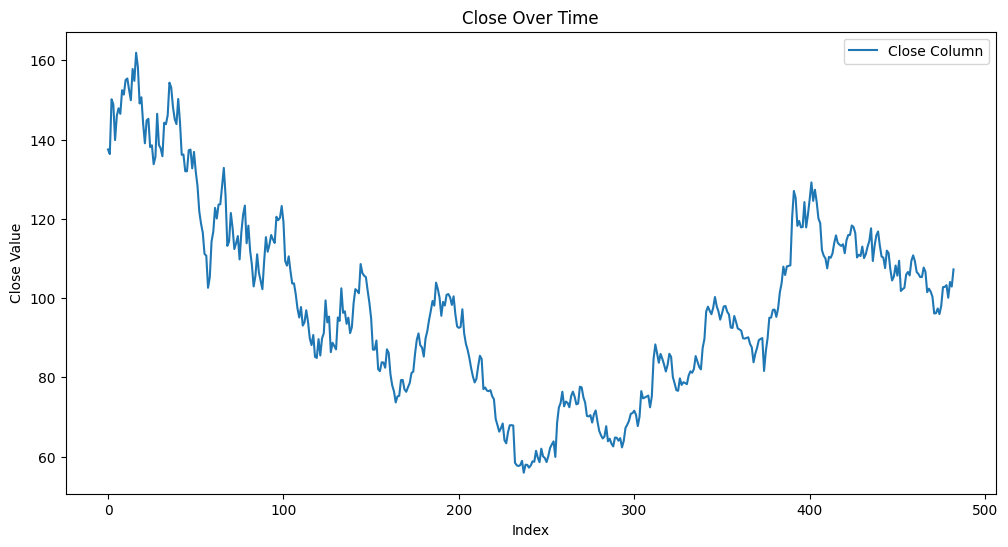

In [415]:
plt.figure(figsize=(12, 6))
plt.plot(df_close.index, df_close, label='Close Column')
plt.title('Close Over Time')
plt.xlabel('Index')
plt.ylabel('Close Value')
plt.legend()
plt.show()

In [416]:
def check_stationarity(ts):
    result = adfuller(ts)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

In [417]:
check_stationarity(df_close)

ADF Statistic: -2.067307088969176
p-value: 0.25786209536712257
Critical Values: {'1%': -3.4439899743408136, '5%': -2.8675550551408353, '10%': -2.569973792117904}


The ADF test is a statistical test for testing the stationarity of a time series. The test hypothesis is as follows:

Null Hypothesis (H0): The time series has a unit root (it is non-stationary).
Alternative Hypothesis (H1): The time series does not have a unit root (it is stationary).
The ADF test statistic is compared against critical values at different significance levels (1%, 5%, and 10%) to determine whether to reject the null hypothesis.

Analyzing our results, :
1) The ADF statistic is less than the critical values at all significance levels. This suggests that we don't have enough evidence to reject the null hypothesis.

2) The p-value is much higher than common significance levels (e.g., 0.05). A high p-value also suggests that we don't have enough evidence to reject the null hypothesis.

Critical Values: The ADF statistic is not more extreme than the critical values at any significance level.

So, Close column data is not stationary.

In [418]:
def plot_autocorrelation(values):
    lags = values.shape[0] // 4

    pd.plotting.autocorrelation_plot(values)

    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(values.values.squeeze(), lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(values, lags=lags, ax=ax2)

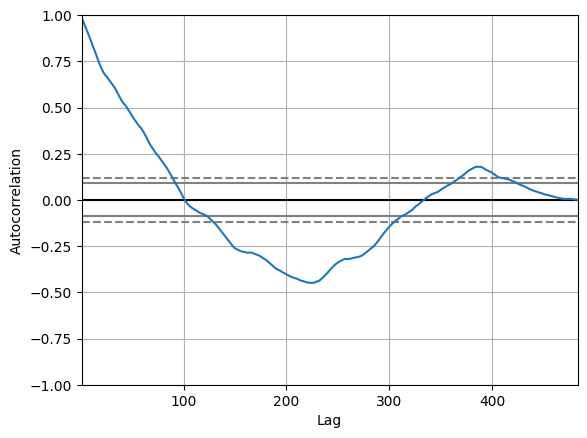

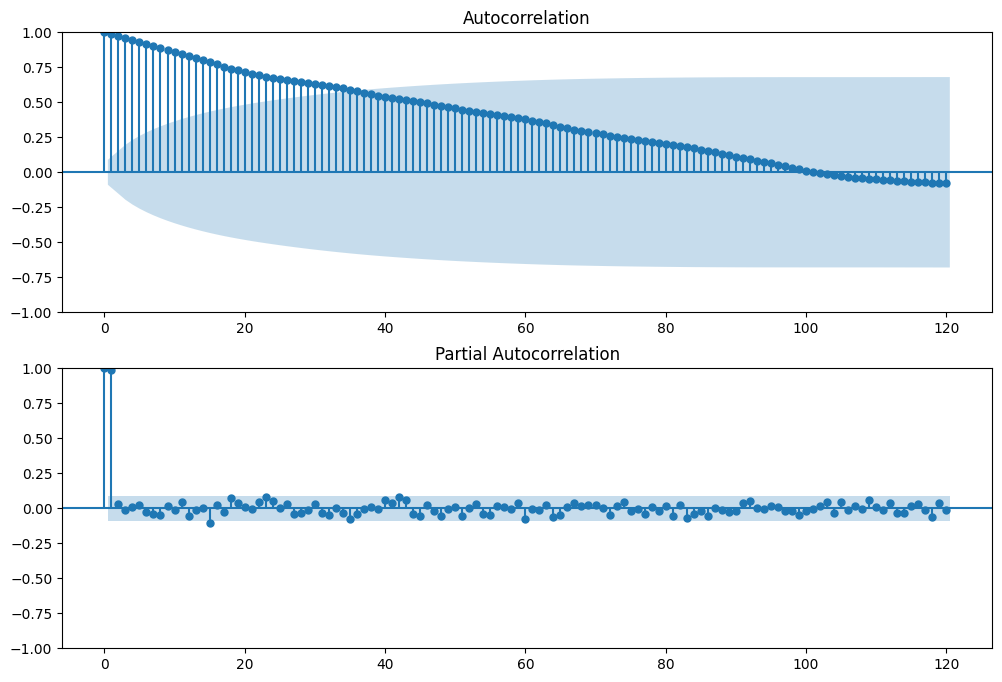

In [419]:
plot_autocorrelation(df_close)

To fix non-stationary nature of the model it can be differenced
```python
df.diff()
```
until it passes the test, but it's also important to not overdifference it

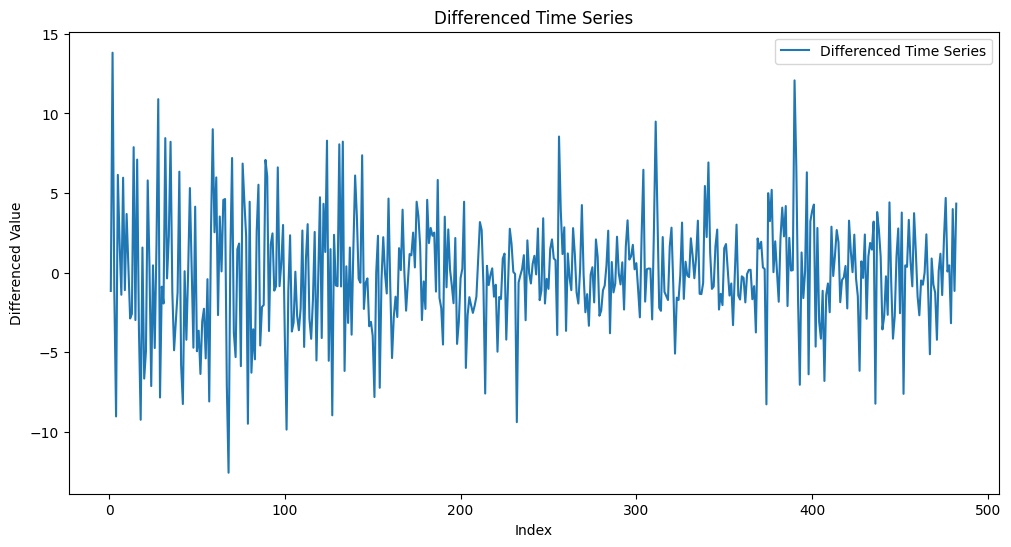

ADF Statistic: -22.60037711829415
p-value: 0.0
Critical Values: {'1%': -3.4440184853599876, '5%': -2.867567599912013, '10%': -2.5699804779975883}


In [420]:
diff_ts = df_close.diff().dropna()
plt.figure(figsize=(12, 6))
plt.plot(diff_ts.index, diff_ts, label='Differenced Time Series')
plt.title('Differenced Time Series')
plt.xlabel('Index')
plt.ylabel('Differenced Value')
plt.legend()
plt.show()
check_stationarity(diff_ts)

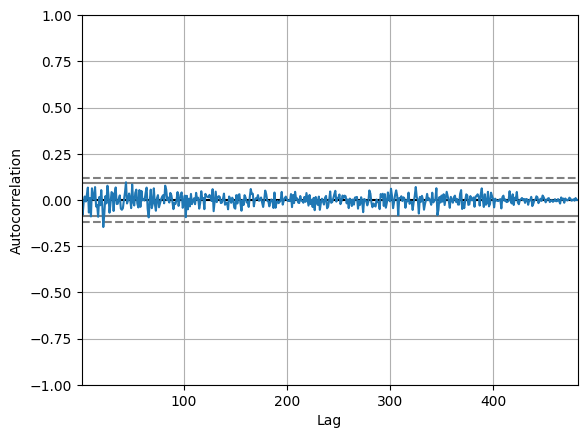

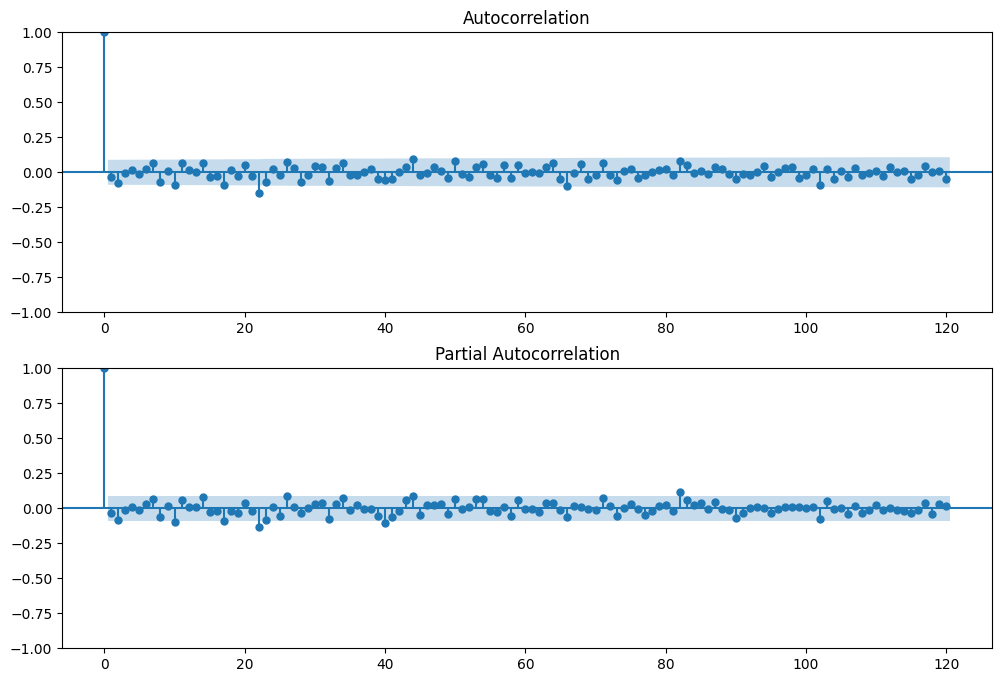

In [421]:
plot_autocorrelation(diff_ts)

As we can see, data is stationary now:
ADF Statistic: The ADF statistic is significantly lower than the critical values at all significance levels (1%, 5%, and 10%). This suggests strong evidence against the null hypothesis, indicating that you can reject the idea of a unit root, and the differenced time series is likely stationary.

BUILDING ARIMA Model

In [422]:
size = int(len(df_close) * TRAIN_TEST_RATIO)
train, test = df_close[0:size], df_close[size:len(df_close)]

Tuning:

In [423]:
p_values = range(0, 10, 1)
q_values = range(0, 10, 1)

best_aic = float("inf")
best_bic = float("inf")
best_p, best_q = None, None
best_model = None

for p, q in itertools.product(p_values, q_values):
    model = ARIMA(train, order=(p, 1, q))
    model_fit = model.fit()
    aic = model_fit.aic
    print(f'\nHaving p,q = {p, q}, aic = {aic}')
    if aic <= best_aic:
        best_aic = aic
        best_p, best_q = p, q
        best_model = model_fit


Having p,q = (0, 0), aic = 2352.9440887731153

Having p,q = (0, 1), aic = 2354.7199398674065

Having p,q = (0, 2), aic = 2353.811590221047

Having p,q = (0, 3), aic = 2355.7961192082994

Having p,q = (0, 4), aic = 2357.609016267371

Having p,q = (0, 5), aic = 2359.5307921982794

Having p,q = (0, 6), aic = 2360.9862603159872

Having p,q = (0, 7), aic = 2361.6991139677275

Having p,q = (0, 8), aic = 2361.4717672344977

Having p,q = (0, 9), aic = 2363.4390292435864

Having p,q = (1, 0), aic = 2354.75668726162

Having p,q = (1, 1), aic = 2355.7248205656574

Having p,q = (1, 2), aic = 2355.801050632812

Having p,q = (1, 3), aic = 2357.6583844984007

Having p,q = (1, 4), aic = 2359.5344662163047

Having p,q = (1, 5), aic = 2361.0174639183874

Having p,q = (1, 6), aic = 2362.7138229087923

Having p,q = (1, 7), aic = 2360.5182566792046

Having p,q = (1, 8), aic = 2362.0018618623176

Having p,q = (1, 9), aic = 2363.9692010876006

Having p,q = (2, 0), aic = 2353.7122545667867

Having p,q = (2, 

d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (2, 6), aic = 2362.040814869174

Having p,q = (2, 7), aic = 2357.5656457306595

Having p,q = (2, 8), aic = 2363.816510475396

Having p,q = (2, 9), aic = 2365.8171604565423

Having p,q = (3, 0), aic = 2355.705414805834

Having p,q = (3, 1), aic = 2357.7050796969115


d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (3, 2), aic = 2352.7453800367994


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (3, 3), aic = 2360.160147211621

Having p,q = (3, 4), aic = 2361.4055581583652


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (3, 5), aic = 2363.324502930036


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (3, 6), aic = 2365.57318068126


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (3, 7), aic = 2359.8583935777724


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (3, 8), aic = 2360.7878364604676


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (3, 9), aic = 2361.734193806556

Having p,q = (4, 0), aic = 2357.6742221897375

Having p,q = (4, 1), aic = 2359.594297813404

Having p,q = (4, 2), aic = 2361.639544701377


d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (4, 3), aic = 2361.449689750645


d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (4, 4), aic = 2356.7550441007133


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (4, 5), aic = 2353.854872176071


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (4, 6), aic = 2352.8055987670987


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (4, 7), aic = 2353.9531626231364


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (4, 8), aic = 2357.5244167587934


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (4, 9), aic = 2359.260359139281

Having p,q = (5, 0), aic = 2359.4817481302434

Having p,q = (5, 1), aic = 2361.397719220228


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (5, 2), aic = 2356.308925504882

Having p,q = (5, 3), aic = 2363.4262085866485


d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 4), aic = 2357.387488007673


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (5, 5), aic = 2361.066239938041


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 6), aic = 2360.8808966382326


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 7), aic = 2355.812851283993


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 8), aic = 2357.793031296832


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (5, 9), aic = 2359.0373141961563

Having p,q = (6, 0), aic = 2360.8984360317

Having p,q = (6, 1), aic = 2362.4937606315666


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (6, 2), aic = 2356.01650325873


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (6, 3), aic = 2359.3150976955703


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (6, 4), aic = 2359.5799212227803


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (6, 5), aic = 2353.5229438054325


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (6, 6), aic = 2362.818552706749


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (6, 7), aic = 2357.069597986497


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (6, 8), aic = 2359.321760503384


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (6, 9), aic = 2362.551133513688

Having p,q = (7, 0), aic = 2361.503922094972

Having p,q = (7, 1), aic = 2360.539940815465

Having p,q = (7, 2), aic = 2358.543537802683


d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace


Having p,q = (7, 3), aic = 2359.949780813218


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (7, 4), aic = 2355.9753424422456


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (7, 5), aic = 2358.9084434714205


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (7, 6), aic = 2357.562932651129


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (7, 7), aic = 2360.323769526045


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (7, 8), aic = 2363.307625811023


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (7, 9), aic = 2365.237792747771

Having p,q = (8, 0), aic = 2362.806827710542

Having p,q = (8, 1), aic = 2362.3581844924006

Having p,q = (8, 2), aic = 2363.6035663491134


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (8, 3), aic = 2362.211004964126


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (8, 4), aic = 2358.4577101511577


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (8, 5), aic = 2359.119060600933


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (8, 6), aic = 2360.3810058872446


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (8, 7), aic = 2365.083705591663


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (8, 8), aic = 2362.237337752462


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Having p,q = (8, 9), aic = 2365.1371468282496

Having p,q = (9, 0), aic = 2364.69464820267

Having p,q = (9, 1), aic = 2363.822969055528

Having p,q = (9, 2), aic = 2365.5939636104904


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (9, 3), aic = 2362.131509310136


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



Having p,q = (9, 4), aic = 2360.2977272397347


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (9, 5), aic = 2364.705815689362


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (9, 6), aic = 2363.24964921288


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (9, 7), aic = 2366.9517535907953


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



Having p,q = (9, 8), aic = 2365.178005103445

Having p,q = (9, 9), aic = 2366.6776419786456


d:\conda\envs\imta\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [424]:
print(f"Best AIC: {best_aic}")
print(f"Best (p, q) values: {best_p, best_q}")

Best AIC: 2352.7453800367994
Best (p, q) values: (3, 2)


In [425]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  434
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1170.373
Date:                Tue, 14 Nov 2023   AIC                           2352.745
Time:                        00:30:21   BIC                           2377.170
Sample:                             0   HQIC                          2362.387
                                - 434                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5705      0.053    -29.411      0.000      -1.675      -1.466
ar.L2         -1.0110      0.083    -12.216      0.000      -1.173      -0.849
ar.L3         -0.0689      0.052     -1.314      0.1

D-parameter passed based on number of times we differenced the model before it became stationary.
For p and q params, we used for loop over their combiations to find the best ones.
Picking the right hyperparameters can significantly impact model's performance.

Model was tuned based on AIC metric, for which lower is better

In [426]:
model_autoARIMA = auto_arima(train,
                      d=1,
                      seasonal=False, 
                      start_P=0)
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  434
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1175.472
Date:                Tue, 14 Nov 2023   AIC                           2352.944
Time:                        00:30:22   BIC                           2357.015
Sample:                             0   HQIC                          2354.551
                                - 434                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        13.3505      0.743     17.959      0.000      11.893      14.807
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                18.53
Prob(Q):                              0.66   Pr

Model trained automatically favors other ARIMA

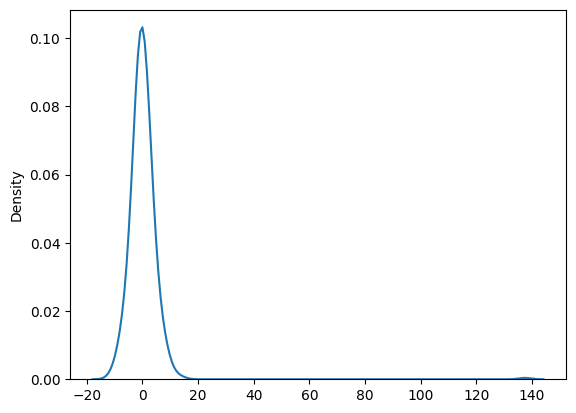

In [427]:
residuals = best_model.resid.set_axis(best_model.resid.index)
sns.kdeplot(residuals)
plt.show()

We got a density plot of the residual error values, suggesting the errors are either Gaussian with some outliers or have some kind of positive skew.

In [428]:
def mean_squared_error(df, actual_col, predicted_col):
    mse = np.mean((df[actual_col] - df[predicted_col]) ** 2)
    return mse

def mean_absolute_error(df, actual_col, predicted_col):
    mae = np.mean(np.abs(df[actual_col] - df[predicted_col]))
    return mae

def root_mean_squared_error(df, actual_col, predicted_col):
    rmse = np.sqrt(mean_squared_error(df, actual_col, predicted_col))
    return rmse

In [429]:
def plot_expected_actual_comparison(results, conf):
    plt.plot(results['Actual'], label='Actual')
    plt.plot(results['Predicted'], label='Predicted')

    lower_series = pd.Series(conf[:, 0])
    upper_series = pd.Series(conf[:, 1])
    plt.fill_between(lower_series.index , lower_series, upper_series, 
                    color='k', alpha=.10)

    plt.legend()
    plt.title('Actual vs Predicted')
    plt.show()

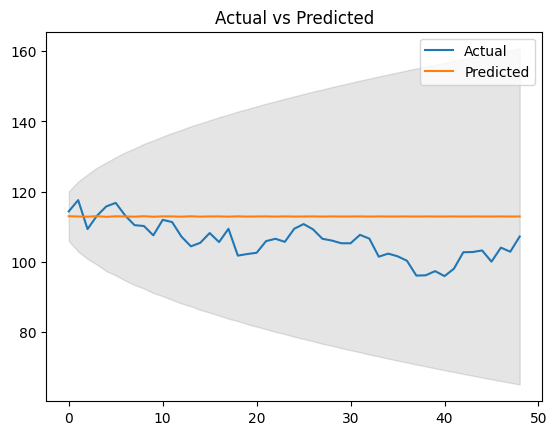

In [430]:
prediction_result = best_model.get_prediction(len(train), len(train) + len(test) - 1)
predictions = prediction_result.predicted_mean
conf = prediction_result.conf_int(alpha=0.05).to_numpy()
results = pd.DataFrame({'Actual': test.reset_index()['Close'], 'Predicted': predictions.reset_index()['predicted_mean']}).reset_index()

plot_expected_actual_comparison(results, conf)

In [431]:
def measure_model_performance(results):
    mse_value = mean_squared_error(results, 'Actual', 'Predicted')
    mae_value = mean_absolute_error(results, 'Actual', 'Predicted')
    rmse_value = root_mean_squared_error(results, 'Actual', 'Predicted')

    print(f'Mean Squared Error: {mse_value}')
    print(f'Mean Absolute Error: {mae_value}')
    print(f'Root Mean Squared Error: {rmse_value}')

In [432]:
measure_model_performance(results)

Mean Squared Error: 74.76472677754298
Mean Absolute Error: 7.4180985420055405
Root Mean Squared Error: 8.646659862486958


Model predictions are pretty close to the real values, but they are very cautious and stick to the mean value on an interval without providing details which are crucial for stock price predictions. At least the confidence interval covers all actual values.

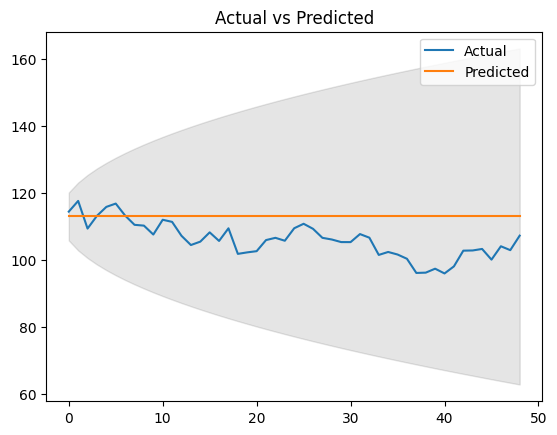

In [433]:
predictions, conf = model_autoARIMA.predict(n_periods=test.shape[0], return_conf_int=True)
results = pd.DataFrame({'Actual': test, 'Predicted': predictions.set_axis(test.index)}).reset_index()

plot_expected_actual_comparison(results, conf)

In [434]:
measure_model_performance(results)

Mean Squared Error: 75.05741979429148
Mean Absolute Error: 7.43795881632653
Root Mean Squared Error: 8.663568536942007


Model generated automatically got worse results and behaves even more cautious.

Analyzing model performance, we got quite decent results for such a messy data.

MSE: The MSE is relatively low, suggesting that, on average, the squared differences between actual and predicted values are small. This is a positive indication of model performance.

MAE: The MAE is also relatively low, indicating that, on average, the absolute differences between actual and predicted values are small. Again, this is a positive sign.

RMSE: The RMSE is bigger than MSE, which is bad as it shows that errors vary from small to big instead of being relatively small all the time.

# Exponential smoothing

In [436]:
def train_exp_smoothing(seasonal_period):
    fit = ExponentialSmoothing(
        train,
        seasonal_periods=seasonal_period,
        trend="add",
        seasonal="mul",
        initialization_method="estimated",
        use_boxcox=True
    ).fit()

    ax = train[-100:].plot(
        figsize=(6, 4),
        marker="o",
        color="black",
        title=f"Forecast (season={seasonal_period})",
    )

    test.plot(ax=ax, alpha=0.25, color="blue", legend=False)

    ax.set_ylabel("AMD stock price")
    ax.set_xlabel("Day (from IPO)")
    predictions = fit.forecast(len(test)).rename("Holt-Winters (add-mul-seasonal)")
    predictions.plot(
        ax=ax, style="--", marker="o", color="green", legend=True
    )
    plt.show()

    results = pd.DataFrame({'Actual': test.reset_index()['Close'], 'Predicted': predictions.reset_index()['Holt-Winters (add-mul-seasonal)']}).reset_index()
    measure_model_performance(results)

Holt-Winters exponential smoothing applies triple exponentiation and relies on data seasonality.

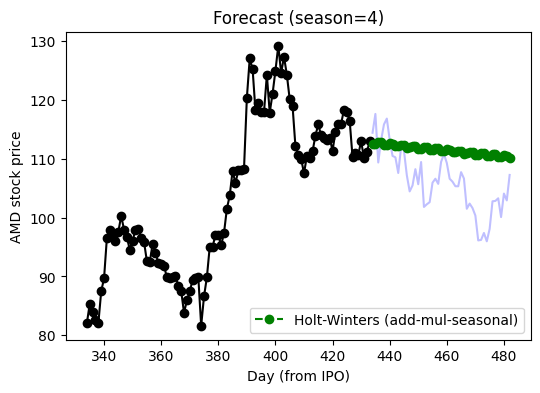

Mean Squared Error: 51.8225585946475
Mean Absolute Error: 6.0790786185655525
Root Mean Squared Error: 7.198788689400981


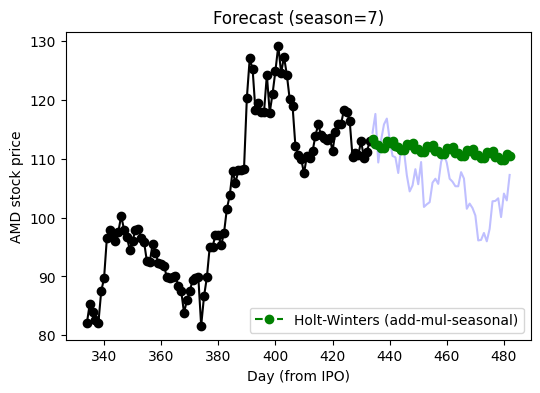

Mean Squared Error: 51.924089094754365
Mean Absolute Error: 6.050449254240534
Root Mean Squared Error: 7.205837154332199


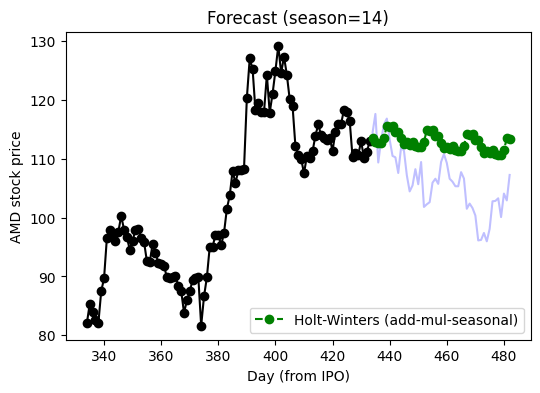

Mean Squared Error: 69.99265185518829
Mean Absolute Error: 7.143204982058943
Root Mean Squared Error: 8.366161118170524


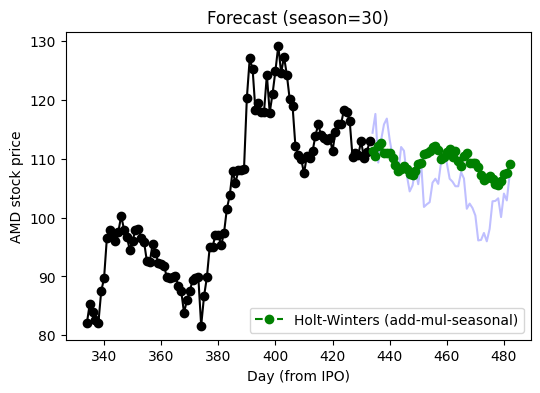

Mean Squared Error: 31.768476767248508
Mean Absolute Error: 4.596013222325169
Root Mean Squared Error: 5.636353144298936


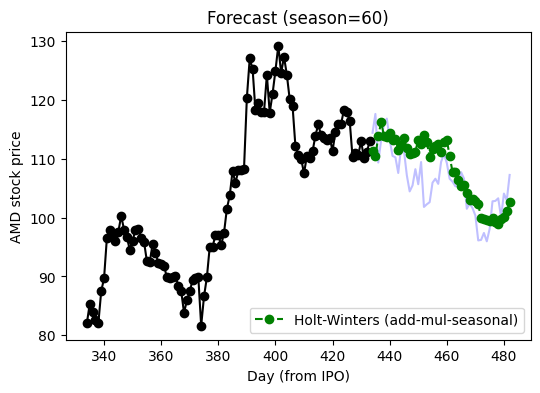

Mean Squared Error: 19.642646206295268
Mean Absolute Error: 3.6985476229210366
Root Mean Squared Error: 4.432002505222133


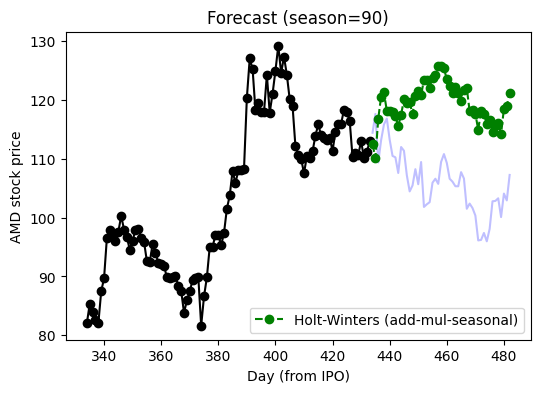

Mean Squared Error: 214.00151133588975
Mean Absolute Error: 13.678894780326708
Root Mean Squared Error: 14.628790494633853


d:\conda\envs\imta\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


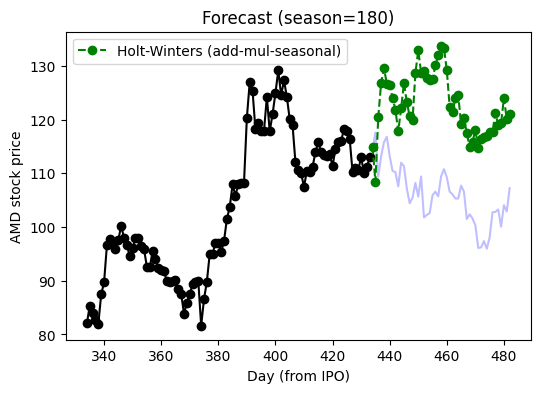

Mean Squared Error: 318.2511981086597
Mean Absolute Error: 17.045106946987172
Root Mean Squared Error: 17.839596354981232


In [437]:
possible_periods = [4, 7, 14, 30, 60, 90, 180]
for period in possible_periods:
    train_exp_smoothing(period)

Tests show that season in our data is a two month. 

Exponential smoothing gives better results and follows the trend better than ARIMA. But it requires the right period set (too small periods behave close to ARIMA while too big periods do extremely wrong decisions)

# Fourier analysis

In [441]:
def train_fourier(seasonal_period, terms_count):
    fourier = Fourier(seasonal_period, order=terms_count)
    dp = DeterministicProcess(index=train.index, additional_terms=[fourier])

    modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)
    fit = modelAutoReg.fit()
    print(fit.summary())

    ax = train[-100:].plot(
        figsize=(6, 4),
        marker="o",
        color="black",
        title=f"Forecast (terms={terms_count})",
    )

    test.plot(ax=ax, alpha=0.25, color="blue", legend=False)

    ax.set_ylabel("AMD stock price")
    ax.set_xlabel("Day (from IPO)")
    predictions = fit.predict(len(train), len(train) + len(test) - 1).rename("Auto regression on Fourier")
    predictions.plot(
        ax=ax, style="--", marker="o", color="green", legend=True
    )
    plt.show()

    results = pd.DataFrame({'Actual': test.reset_index()['Close'], 'Predicted': predictions.reset_index()['Auto regression on Fourier']}).reset_index()
    measure_model_performance(results)

Fourier analysis requires data about period and amount of terms to be used. We already have an assumption about the length of the full period so model will be tuned by terms count.

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1175.168
Method:               Conditional MLE   S.D. of innovations              3.651
Date:                Tue, 14 Nov 2023   AIC                           2354.335
Time:                        00:37:05   BIC                           2362.477
Sample:                             1   HQIC                          2357.549
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Close.L1       0.9986      0.002    572.300      0.000       0.995       1.002
                                    Roots                                    
                  Real          Imaginary           M

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


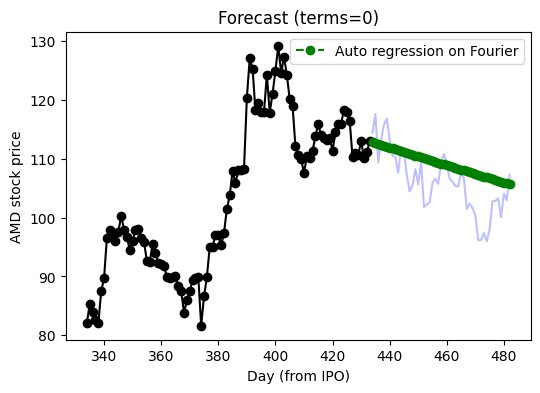

Mean Squared Error: 24.91090169189408
Mean Absolute Error: 4.031835700210214
Root Mean Squared Error: 4.991082216503158
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1173.417
Method:               Conditional MLE   S.D. of innovations              3.637
Date:                Tue, 14 Nov 2023   AIC                           2354.833
Time:                        00:37:05   BIC                           2371.116
Sample:                             1   HQIC                          2361.261
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4373      0.248      1.765      0.078      -0.048       0.923
cos(1,60)  

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


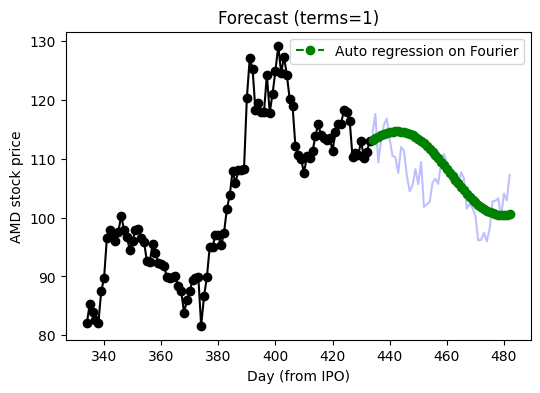

Mean Squared Error: 21.877413712558734
Mean Absolute Error: 3.7877017667178143
Root Mean Squared Error: 4.677329763076229
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1171.859
Method:               Conditional MLE   S.D. of innovations              3.623
Date:                Tue, 14 Nov 2023   AIC                           2355.718
Time:                        00:37:05   BIC                           2380.142
Sample:                             1   HQIC                          2365.360
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4335      0.247      1.755      0.079      -0.051       0.918
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


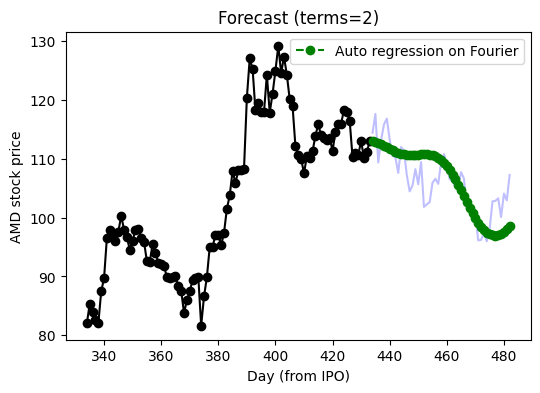

Mean Squared Error: 15.837202464117748
Mean Absolute Error: 3.1403602784052165
Root Mean Squared Error: 3.9795982792384645
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1171.524
Method:               Conditional MLE   S.D. of innovations              3.621
Date:                Tue, 14 Nov 2023   AIC                           2359.047
Time:                        00:37:05   BIC                           2391.613
Sample:                             1   HQIC                          2371.903
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4357      0.247      1.765      0.078      -0.048       0.919
cos(1,60

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


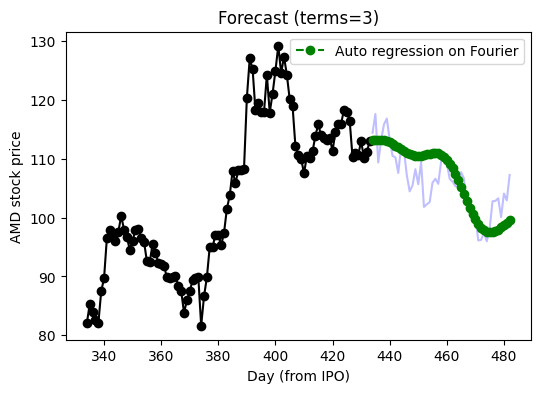

Mean Squared Error: 14.737165748927893
Mean Absolute Error: 3.056310124506719
Root Mean Squared Error: 3.8389016331403822
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1170.619
Method:               Conditional MLE   S.D. of innovations              3.613
Date:                Tue, 14 Nov 2023   AIC                           2361.238
Time:                        00:37:06   BIC                           2401.945
Sample:                             1   HQIC                          2377.308
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4394      0.246      1.784      0.074      -0.043       0.922
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


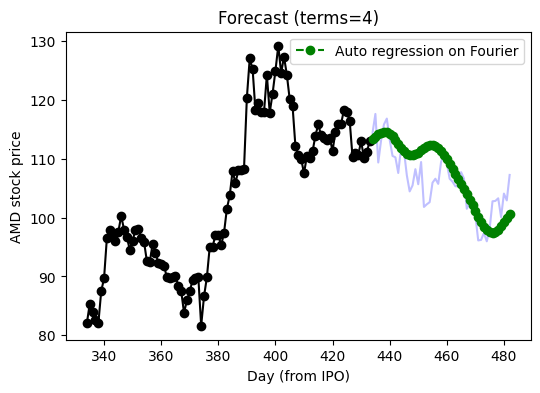

Mean Squared Error: 17.16109377303546
Mean Absolute Error: 3.280341176828981
Root Mean Squared Error: 4.142595052987374
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1169.317
Method:               Conditional MLE   S.D. of innovations              3.602
Date:                Tue, 14 Nov 2023   AIC                           2362.634
Time:                        00:37:06   BIC                           2411.483
Sample:                             1   HQIC                          2381.918
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4398      0.246      1.791      0.073      -0.042       0.921
cos(1,60)  

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


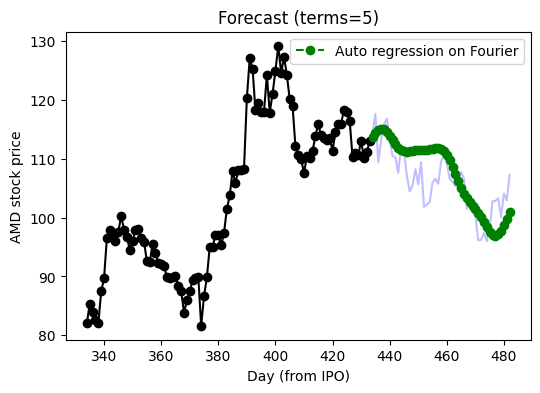

Mean Squared Error: 17.65048514649279
Mean Absolute Error: 3.4088452657171033
Root Mean Squared Error: 4.201248046294433


C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1169.170
Method:               Conditional MLE   S.D. of innovations              3.601
Date:                Tue, 14 Nov 2023   AIC                           2366.340
Time:                        00:37:06   BIC                           2423.330
Sample:                             1   HQIC                          2388.838
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4390      0.246      1.788      0.074      -0.042       0.920
cos(1,60)      0.1371      0.245      0.560      0.575      -0.343       0.617
sin(2,60)      0.2678      0.245      1.094      0.2

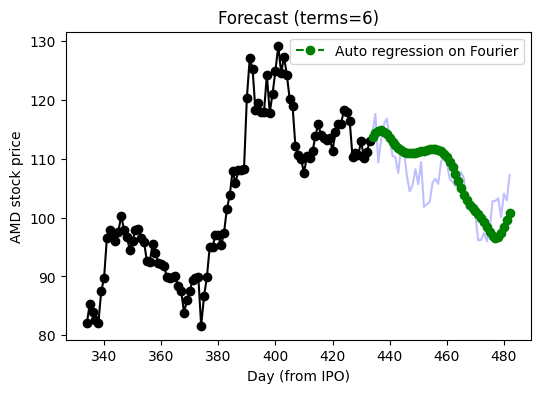

Mean Squared Error: 17.330964868301223
Mean Absolute Error: 3.3395833032833555
Root Mean Squared Error: 4.163047545765148


C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1167.971
Method:               Conditional MLE   S.D. of innovations              3.591
Date:                Tue, 14 Nov 2023   AIC                           2367.943
Time:                        00:37:06   BIC                           2433.075
Sample:                             1   HQIC                          2393.654
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4366      0.245      1.783      0.075      -0.043       0.916
cos(1,60)      0.1347      0.244      0.552      0.581      -0.344       0.613
sin(2,60)      0.2668      0.244      1.093      0.2

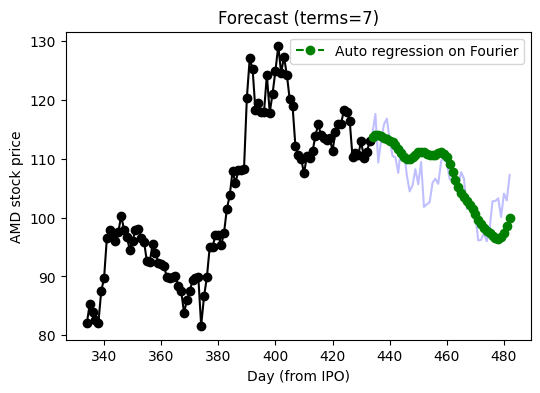

Mean Squared Error: 16.020778748952495
Mean Absolute Error: 3.1816871722166122
Root Mean Squared Error: 4.0025965008919515
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1167.290
Method:               Conditional MLE   S.D. of innovations              3.585
Date:                Tue, 14 Nov 2023   AIC                           2370.580
Time:                        00:37:06   BIC                           2443.853
Sample:                             1   HQIC                          2399.505
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4372      0.244      1.788      0.074      -0.042       0.916
cos(1,60

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


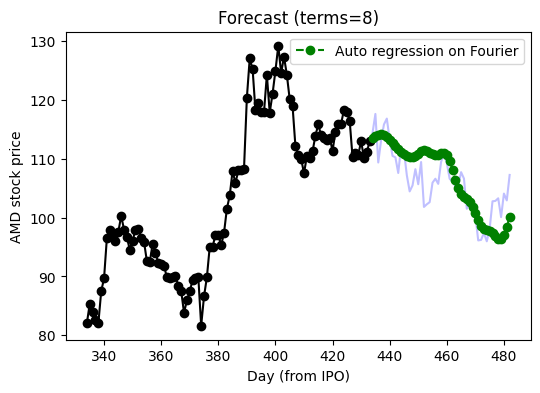

Mean Squared Error: 16.317865782816877
Mean Absolute Error: 3.2028165540051403
Root Mean Squared Error: 4.0395378179708725
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1165.604
Method:               Conditional MLE   S.D. of innovations              3.572
Date:                Tue, 14 Nov 2023   AIC                           2371.209
Time:                        00:37:07   BIC                           2452.623
Sample:                             1   HQIC                          2403.348
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4367      0.243      1.793      0.073      -0.041       0.914
cos(1,60

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


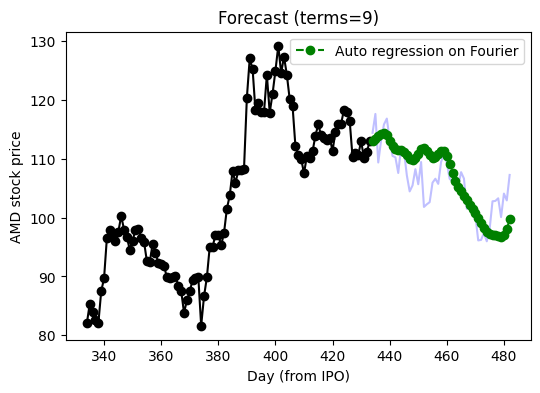

Mean Squared Error: 16.00827351251931
Mean Absolute Error: 3.1347549251424334
Root Mean Squared Error: 4.001034055406091
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1165.085
Method:               Conditional MLE   S.D. of innovations              3.567
Date:                Tue, 14 Nov 2023   AIC                           2374.170
Time:                        00:37:07   BIC                           2463.727
Sample:                             1   HQIC                          2409.524
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4365      0.243      1.795      0.073      -0.040       0.913
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


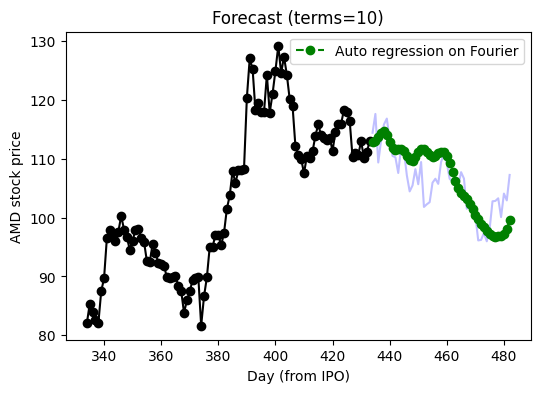

Mean Squared Error: 15.974517687116633
Mean Absolute Error: 3.137766515697495
Root Mean Squared Error: 3.9968134416202905
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1164.653
Method:               Conditional MLE   S.D. of innovations              3.564
Date:                Tue, 14 Nov 2023   AIC                           2377.305
Time:                        00:37:07   BIC                           2475.003
Sample:                             1   HQIC                          2415.872
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4364      0.243      1.796      0.072      -0.040       0.913
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


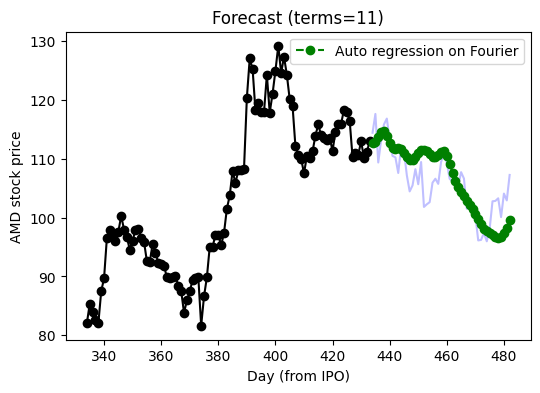

Mean Squared Error: 15.927598784141649
Mean Absolute Error: 3.132258539160045
Root Mean Squared Error: 3.990939586631405
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1163.054
Method:               Conditional MLE   S.D. of innovations              3.551
Date:                Tue, 14 Nov 2023   AIC                           2378.108
Time:                        00:37:07   BIC                           2483.947
Sample:                             1   HQIC                          2419.889
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4379      0.242      1.809      0.070      -0.037       0.912
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


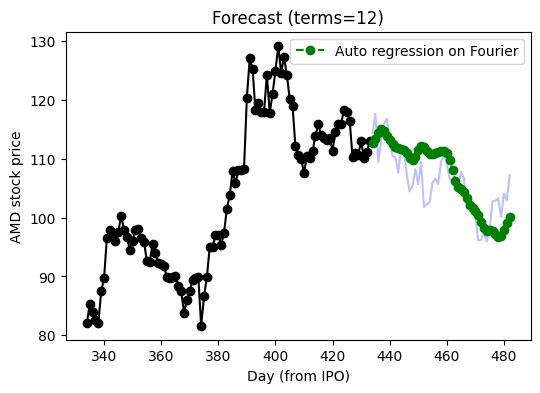

Mean Squared Error: 16.495199366538277
Mean Absolute Error: 3.2300540114782197
Root Mean Squared Error: 4.061428242199814
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1162.290
Method:               Conditional MLE   S.D. of innovations              3.544
Date:                Tue, 14 Nov 2023   AIC                           2380.580
Time:                        00:37:07   BIC                           2494.560
Sample:                             1   HQIC                          2425.574
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4373      0.242      1.810      0.070      -0.036       0.911
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


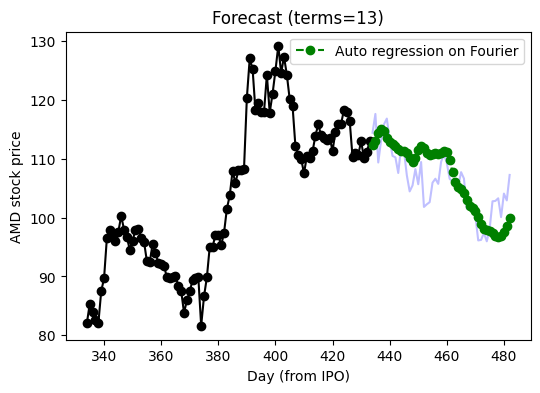

Mean Squared Error: 16.347947362214473
Mean Absolute Error: 3.224094584900701
Root Mean Squared Error: 4.043259497263869
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1162.232
Method:               Conditional MLE   S.D. of innovations              3.544
Date:                Tue, 14 Nov 2023   AIC                           2384.464
Time:                        00:37:07   BIC                           2506.586
Sample:                             1   HQIC                          2432.673
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4373      0.242      1.810      0.070      -0.036       0.911
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


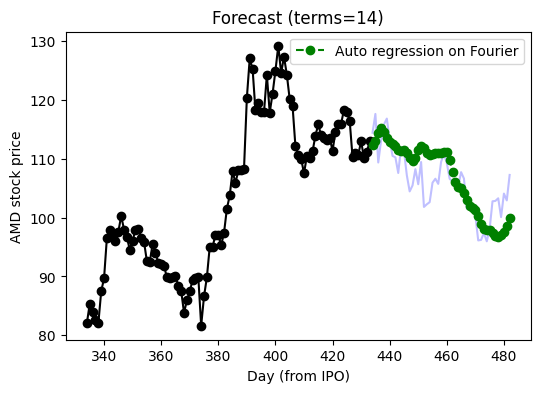

Mean Squared Error: 16.42383149518926
Mean Absolute Error: 3.23358728972322
Root Mean Squared Error: 4.05263266225663
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1161.681
Method:               Conditional MLE   S.D. of innovations              3.539
Date:                Tue, 14 Nov 2023   AIC                           2387.361
Time:                        00:37:08   BIC                           2517.625
Sample:                             1   HQIC                          2438.784
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4369      0.241      1.810      0.070      -0.036       0.910
cos(1,60)    

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


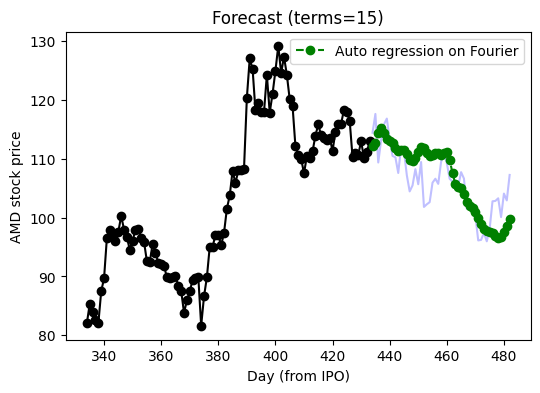

Mean Squared Error: 16.26129131793843
Mean Absolute Error: 3.199647450680359
Root Mean Squared Error: 4.03252914657023
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1158.866
Method:               Conditional MLE   S.D. of innovations              3.516
Date:                Tue, 14 Nov 2023   AIC                           2385.733
Time:                        00:37:08   BIC                           2524.138
Sample:                             1   HQIC                          2440.369
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4354      0.240      1.816      0.069      -0.034       0.905
cos(1,60)   

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


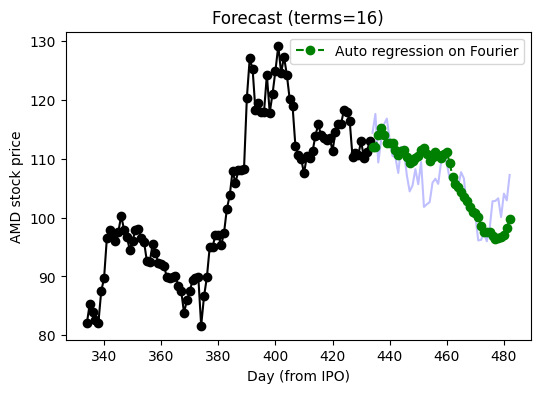

Mean Squared Error: 16.085020716282102
Mean Absolute Error: 3.1568884429941004
Root Mean Squared Error: 4.010613508714359
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1158.372
Method:               Conditional MLE   S.D. of innovations              3.512
Date:                Tue, 14 Nov 2023   AIC                           2388.744
Time:                        00:37:08   BIC                           2535.291
Sample:                             1   HQIC                          2446.595
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4360      0.239      1.821      0.069      -0.033       0.905
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


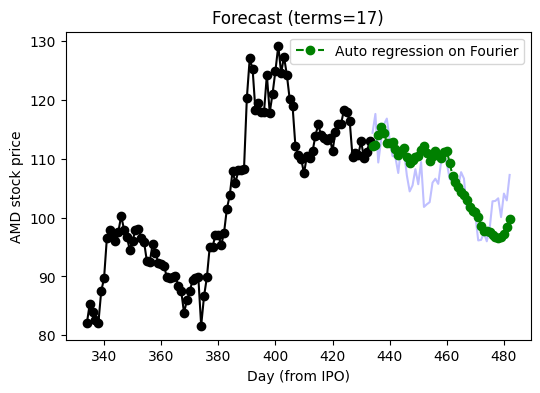

Mean Squared Error: 16.13114778232868
Mean Absolute Error: 3.196241311669352
Root Mean Squared Error: 4.016360016523504
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1156.578
Method:               Conditional MLE   S.D. of innovations              3.498
Date:                Tue, 14 Nov 2023   AIC                           2389.156
Time:                        00:37:08   BIC                           2543.844
Sample:                             1   HQIC                          2450.220
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4348      0.238      1.823      0.068      -0.033       0.902
cos(1,60)  

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


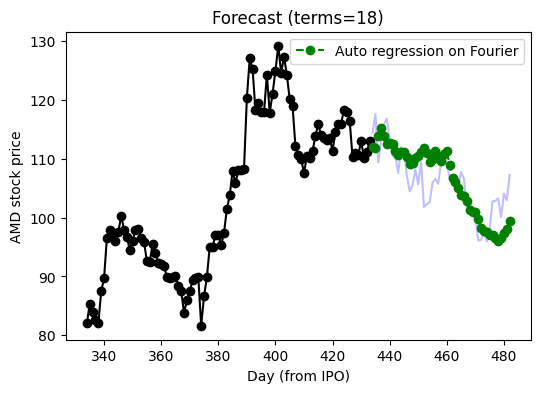

Mean Squared Error: 16.039456734115873
Mean Absolute Error: 3.170206207564764
Root Mean Squared Error: 4.00492905481681


C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1156.429
Method:               Conditional MLE   S.D. of innovations              3.497
Date:                Tue, 14 Nov 2023   AIC                           2392.858
Time:                        00:37:08   BIC                           2555.688
Sample:                             1   HQIC                          2457.137
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4350      0.238      1.824      0.068      -0.032       0.902
cos(1,60)      0.1342      0.238      0.565      0.572      -0.332       0.600
sin(2,60)      0.2647      0.238      1.114      0.2

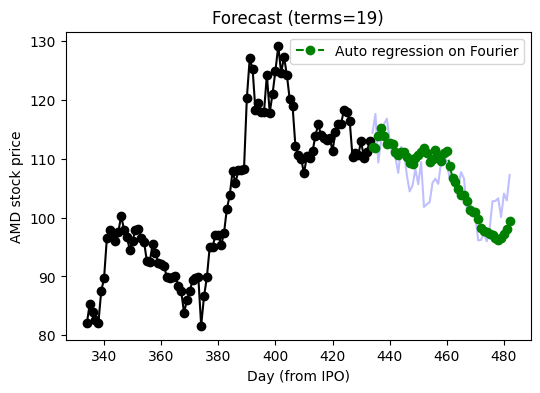

Mean Squared Error: 16.08550291317036
Mean Absolute Error: 3.1722161369718416
Root Mean Squared Error: 4.010673623366823
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1155.492
Method:               Conditional MLE   S.D. of innovations              3.489
Date:                Tue, 14 Nov 2023   AIC                           2394.985
Time:                        00:37:09   BIC                           2565.956
Sample:                             1   HQIC                          2462.477
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4344      0.238      1.826      0.068      -0.032       0.901
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


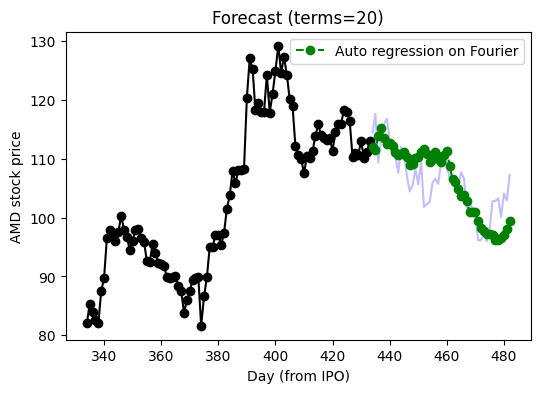

Mean Squared Error: 16.05301400227909
Mean Absolute Error: 3.161886421345891
Root Mean Squared Error: 4.006621270132615
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1154.291
Method:               Conditional MLE   S.D. of innovations              3.479
Date:                Tue, 14 Nov 2023   AIC                           2396.582
Time:                        00:37:09   BIC                           2575.694
Sample:                             1   HQIC                          2467.288
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4343      0.237      1.831      0.067      -0.031       0.899
cos(1,60)  

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


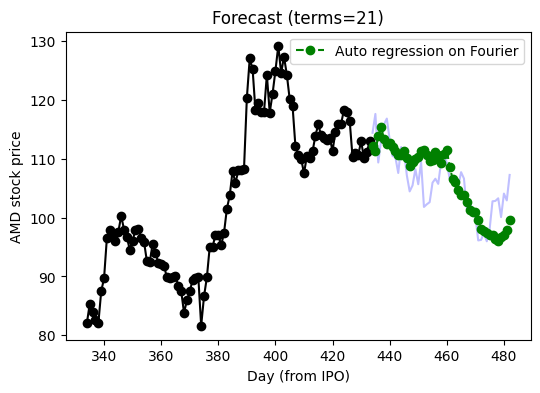

Mean Squared Error: 16.012143678450723
Mean Absolute Error: 3.1652343636907485
Root Mean Squared Error: 4.001517671890345
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1153.016
Method:               Conditional MLE   S.D. of innovations              3.469
Date:                Tue, 14 Nov 2023   AIC                           2398.031
Time:                        00:37:09   BIC                           2585.285
Sample:                             1   HQIC                          2471.951
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4340      0.237      1.835      0.067      -0.030       0.898
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


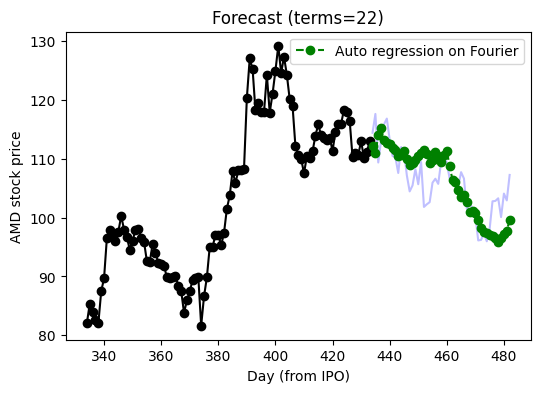

Mean Squared Error: 16.012023561598852
Mean Absolute Error: 3.146906639399928
Root Mean Squared Error: 4.001502662950363
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1151.012
Method:               Conditional MLE   S.D. of innovations              3.453
Date:                Tue, 14 Nov 2023   AIC                           2398.023
Time:                        00:37:10   BIC                           2593.419
Sample:                             1   HQIC                          2475.157
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4350      0.235      1.848      0.065      -0.026       0.896
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


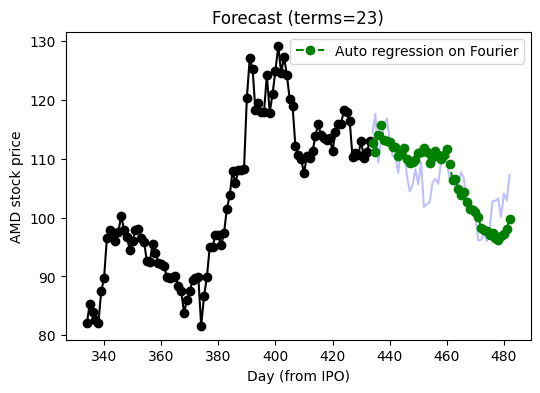

Mean Squared Error: 16.27673510106192
Mean Absolute Error: 3.2033610608584606
Root Mean Squared Error: 4.034443592499704
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1150.986
Method:               Conditional MLE   S.D. of innovations              3.453
Date:                Tue, 14 Nov 2023   AIC                           2401.972
Time:                        00:37:10   BIC                           2605.509
Sample:                             1   HQIC                          2482.320
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4351      0.235      1.848      0.065      -0.026       0.896
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


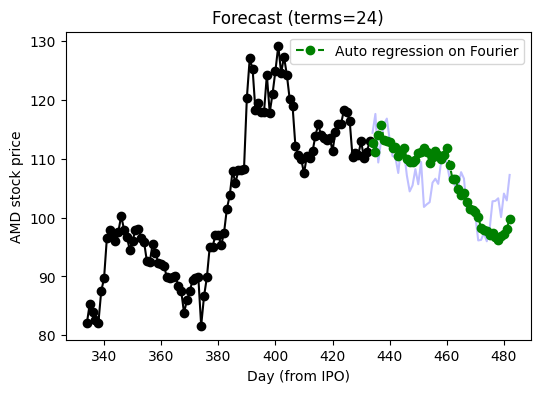

Mean Squared Error: 16.277477216062152
Mean Absolute Error: 3.2055543951248318
Root Mean Squared Error: 4.0345355638613665
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1150.012
Method:               Conditional MLE   S.D. of innovations              3.445
Date:                Tue, 14 Nov 2023   AIC                           2404.024
Time:                        00:37:10   BIC                           2615.703
Sample:                             1   HQIC                          2487.586
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4343      0.235      1.849      0.064      -0.026       0.895
cos(1,60

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


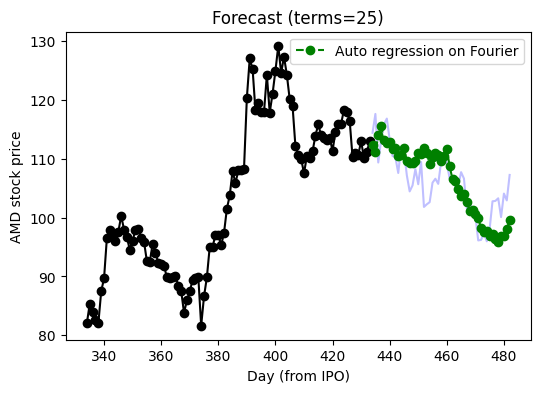

Mean Squared Error: 16.286711101881203
Mean Absolute Error: 3.177981559092933
Root Mean Squared Error: 4.035679757101795
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1149.623
Method:               Conditional MLE   S.D. of innovations              3.442
Date:                Tue, 14 Nov 2023   AIC                           2407.246
Time:                        00:37:10   BIC                           2627.066
Sample:                             1   HQIC                          2494.022
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4342      0.235      1.850      0.064      -0.026       0.894
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


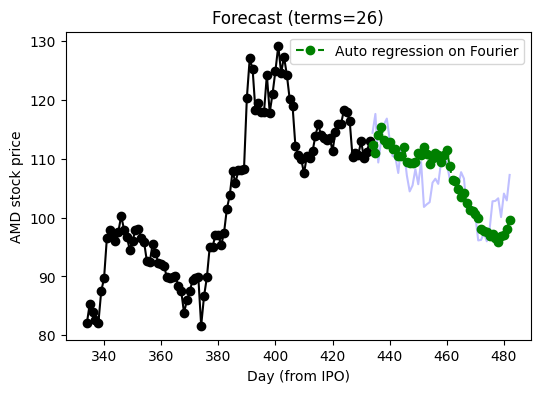

Mean Squared Error: 16.29188975446951
Mean Absolute Error: 3.1654922177989793
Root Mean Squared Error: 4.036321314572158
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1149.109
Method:               Conditional MLE   S.D. of innovations              3.438
Date:                Tue, 14 Nov 2023   AIC                           2410.219
Time:                        00:37:10   BIC                           2638.180
Sample:                             1   HQIC                          2500.208
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4339      0.234      1.851      0.064      -0.026       0.893
cos(1,60) 

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


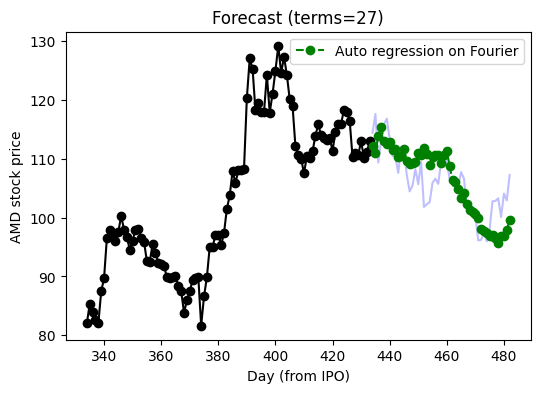

Mean Squared Error: 16.18849997246712
Mean Absolute Error: 3.139766252357951
Root Mean Squared Error: 4.023493503470227
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1148.577
Method:               Conditional MLE   S.D. of innovations              3.434
Date:                Tue, 14 Nov 2023   AIC                           2413.153
Time:                        00:37:11   BIC                           2649.256
Sample:                             1   HQIC                          2506.357
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4333      0.234      1.851      0.064      -0.026       0.892
cos(1,60)  

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


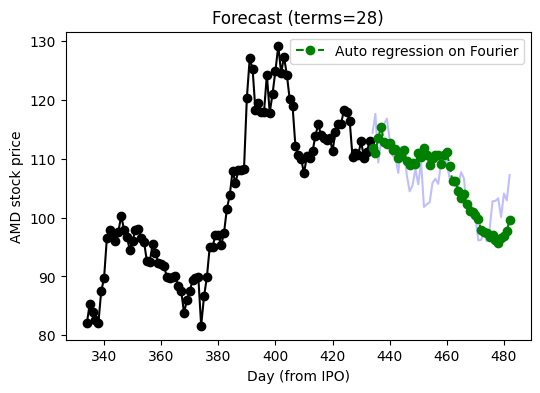

Mean Squared Error: 16.089331098237746
Mean Absolute Error: 3.1243150413835075
Root Mean Squared Error: 4.011150844612771
                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  434
Model:                     AutoReg(1)   Log Likelihood               -1148.337
Method:               Conditional MLE   S.D. of innovations              3.432
Date:                Tue, 14 Nov 2023   AIC                           2416.673
Time:                        00:37:11   BIC                           2660.917
Sample:                             1   HQIC                          2513.091
                                  434                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,60)      0.4336      0.234      1.853      0.064      -0.025       0.892
cos(1,60)

C:\Users\strel\AppData\Local\Temp\ipykernel_19764\2155635110.py:5: SpecificationWarning: When using deterministic, trend must be "n" and seasonal must be False.
  modelAutoReg = AutoReg(train, 1, trend="t", deterministic=dp)


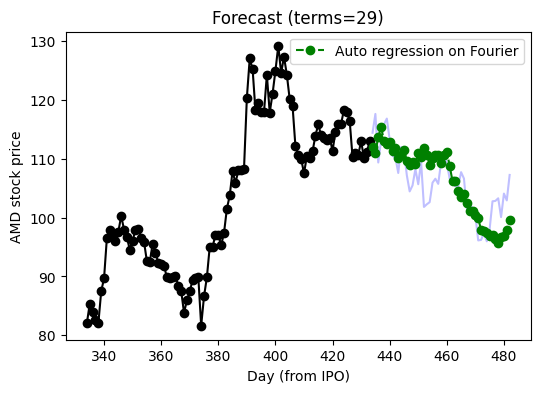

Mean Squared Error: 16.16660837009862
Mean Absolute Error: 3.129818372512703
Root Mean Squared Error: 4.020772111186932


In [442]:
period = 60
possible_terms_counts = list(range(0, period // 2, 1))

for terms_count in possible_terms_counts:
    train_fourier(period, terms_count)

Fourier series generate pretty similar results starting from 7 terms. Fourier series results are even better than results achieved by exponential smoothing. Trend approximation also looks much better than both previous models, which can be the biggest benefit, given that none of the models are really accurate in terms of MSE.